# CSE 6240 - Web Search & Text Mining - Homework 1
                                             


In [1]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
%matplotlib inline

# Question 3.a

In [3]:
df = pd.read_csv('ml-100k/ua.base', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [4]:
test_df = pd.read_csv('ml-100k/ua.test', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [5]:
user_df = df.groupby(['user_id']).count()
item_df = df.groupby(['item_id']).count()

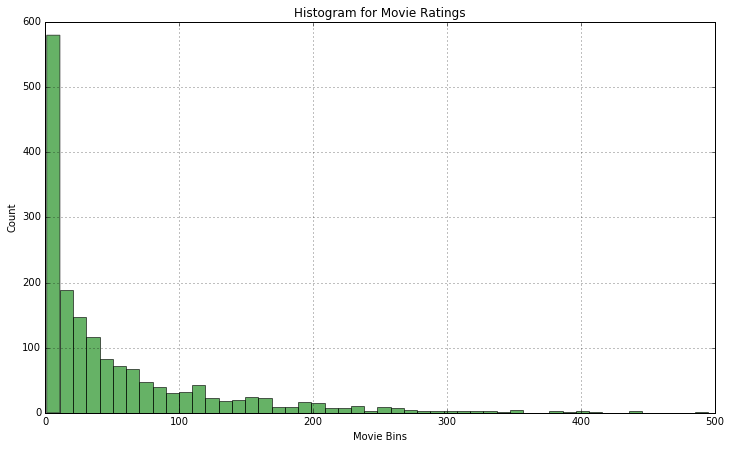

In [6]:
plt.figure(1, figsize=(12, 7))
plt.xlabel('Movie Bins')
plt.ylabel('Count')
plt.title('Histogram for Movie Ratings')
plt.hist(item_df['user_id'], bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# Question 3.b

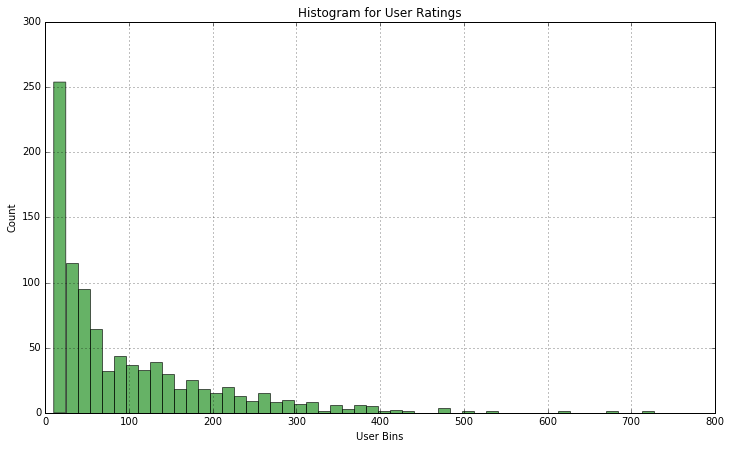

In [233]:
plt.figure(2, figsize=(12, 7))
plt.xlabel('User Bins')
plt.ylabel('Count')
plt.title('Histogram for User Ratings')
plt.hist(user_df['item_id'], bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# Question 4.a

In [253]:
user = df['user_id'].values
item = df['item_id'].values
ratings = df['rating'].values
mat = csc_matrix((ratings, (user, item)))
mat = mat[1:,1:]

1


In [242]:
u_test = test_df['user_id'].values
i_test = test_df['item_id'].values
t_rating = test_df['rating'].values

In [243]:
# Segregate test group into 4 groups for plotting question
u_one_test = []
i_one_test = []

u_two_test = []
i_two_test = []

u_three_test = []
i_three_test = []

u_four_test = []
i_four_test = []

u_five_test = []
i_five_test = []

for i,val in enumerate(t_rating):
    if val == 1:
        u_one_test.append(u_test[i])
        i_one_test.append(i_test[i])
    if val == 2:
        u_two_test.append(u_test[i])
        i_two_test.append(i_test[i])
    if val == 3:
        u_three_test.append(u_test[i])
        i_three_test.append(i_test[i])
    if val == 4:
        u_four_test.append(u_test[i])
        i_four_test.append(i_test[i])
    if val == 5:
        u_five_test.append(u_test[i])
        i_five_test.append(i_test[i])
        

In [10]:
mat_sum = mat.sum()
mu = mat_sum/float(len(user))
u_count = mat.getnnz(axis=1)
i_count = mat.getnnz(axis=0)

In [240]:
emp_b_u = np.zeros(mat.shape[0])
emp_b_i = np.zeros(mat.shape[1])
u_step = np.zeros(mat.shape[0])
i_step = np.zeros(mat.shape[1])
users_per_column = [[]] * mat.shape[1]

for i, val in enumerate(emp_b_u):
    if u_count[i] == 0:
        emp_b_u[i] = 0
    else:
        emp_b_u[i] = (mat.getrow(i).sum()/float(u_count[i])) - mu

for i, val in enumerate(emp_b_i):
    if i_count[i] == 0:
        emp_b_i[i] = 0
        users_per_column[i] = []
    else:
        users_per_column[i] = mat.getcol(i).toarray().nonzero()[0]
        indices = mat.getcol(i).indices
        user_sum = 0.0
        for ind in indices:
            user_sum += emp_b_u[ind]

        emp_b_i[i] = ((mat.getcol(i).sum()-user_sum)/float(i_count[i])) - mu

In [241]:
sigma = 0

for i, val in enumerate(t_rating):
    sigma += (val - (mu + emp_b_u[int(u_test[i])-1] + emp_b_i[int(i_test[i])-1]))**2

rmse = (sigma/float(len(t_rating)))**0.5
print "4a ", rmse

4a  0.981683850142


# Question 4.b

In [257]:
min_rmse = 0
b_u = emp_b_u.copy()
b_i = emp_b_i.copy()
opt_b_u = b_u.copy()
opt_b_i = b_i.copy()

for z in range(100000):
    # lambda of cost function
    lambda_val = 25
    sq_diff = 0
    b_u_square_sum = 0
    b_i_square_sum = 0

    # find cost value
    for i, val in enumerate(ratings):
        u_index = int(user[i])-1
        i_index = int(item[i])-1
        sq_diff += (val - mu - b_u[u_index] - b_i[i_index])**2
        b_u_square_sum += b_u[u_index]**2
        b_i_square_sum += b_i[i_index]**2

    reg_val = lambda_val * (b_u_square_sum + b_u_square_sum)
    cost = sq_diff + reg_val
    
    # u step calculation
    for i, val in enumerate(b_u):
        if u_count[i] == 0:
            u_step[i] = 0
        else:
            r_ui = mat.getrow(i).sum()
            u_sum = mu * u_count[i]
            bu_sum = b_u[i] * u_count[i]
            bi_sum = 0
            i_indices = mat.getrow(i).indices
            for index in i_indices:
                bi_sum += b_i[index]

            u_step[i] = -2*(r_ui - u_sum - bu_sum - bi_sum) + 2*lambda_val*bu_sum

    # i step calculation
    for i, val in enumerate(b_i):
        if i_count[i] == 0:
            i_step[i] = 0
        else:
            r_ui = mat.getcol(i).sum()
            u_sum = mu * i_count[i]
            bi_sum = b_i[i] * i_count[i]
            bu_sum = 0
            u_indices = mat.getcol(i).indices
            for index in u_indices:
                bu_sum += b_u[index]

            i_step[i] = -2*(r_ui - u_sum - bu_sum - bi_sum) + 2*lambda_val*bi_sum

    b_u -= u_step * (1 / float(100 * len(t_rating)))
    b_i -= i_step * (1 / float(100 * len(t_rating)))
    sigma = 0

    for i, val in enumerate(t_rating):
        sigma += (val - (mu + b_u[int(u_test[i])-1] + b_i[int(i_test[i])-1]))**2

    rmse = (sigma/float(len(t_rating)))**0.5
    if min_rmse == 0:
        min_rmse = rmse
        opt_b_u = b_u.copy()
        opt_b_i = b_i.copy()
    else:
        if rmse < min_rmse:
            min_rmse = rmse
            opt_b_u = b_u.copy()
            opt_b_i = b_i.copy()
        else:
            break

print "4b ", min_rmse

4b  0.979029254278


# 4.c.ii Empirical RMSE

In [264]:
# Populate error arrays for each rating group
one_error_arr = []
two_error_arr = []
three_error_arr = []
four_error_arr = []
five_error_arr = []
sigma = 0
for i, val in enumerate(u_one_test):
    error = abs(1-(mu+b_u[int(u_one_test[i])-1] + b_i[int(i_one_test[i])-1]))
    one_error_arr.append(error)
    
for i, val in enumerate(u_two_test):
    error = abs(2-(mu+b_u[int(u_two_test[i])-1] + b_i[int(i_two_test[i])-1]))
    two_error_arr.append(error)
    
for i, val in enumerate(u_three_test):
    error = abs(3-(mu+b_u[int(u_three_test[i])-1] + b_i[int(i_three_test[i])-1]))
    three_error_arr.append(error)
    
for i, val in enumerate(u_four_test):
    error = abs(4-(mu+b_u[int(u_four_test[i])-1] + b_i[int(i_four_test[i])-1]))
    four_error_arr.append(error)

for i, val in enumerate(u_five_test):
    error = abs(5-(mu+b_u[int(u_five_test[i])-1] + b_i[int(i_five_test[i])-1]))
    five_error_arr.append(error)

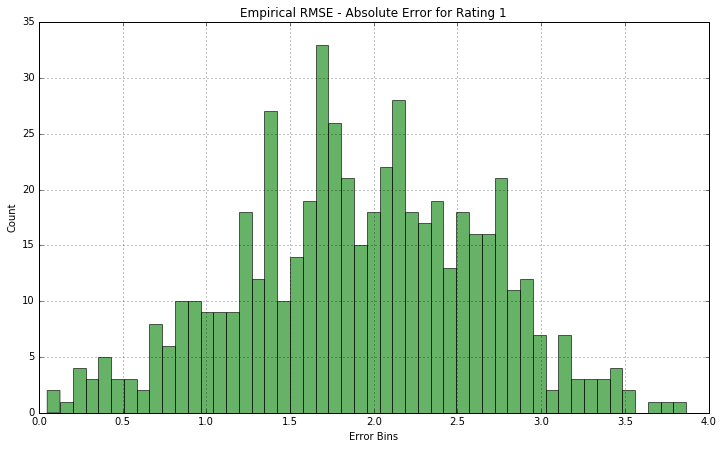

In [265]:
plt.figure(3, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for Rating 1')
plt.hist(one_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

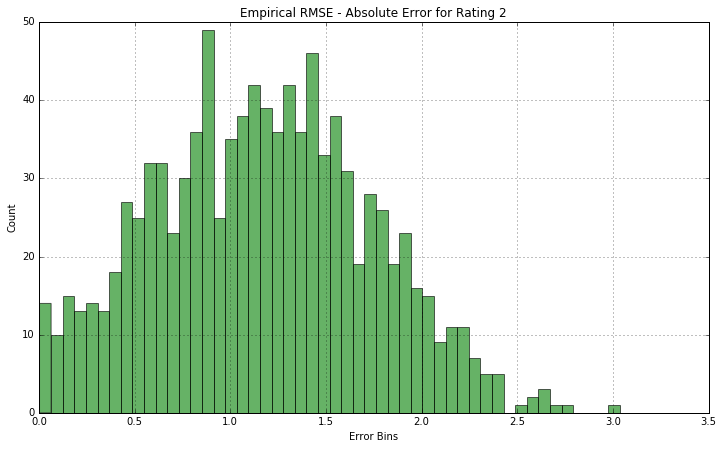

In [266]:
plt.figure(4, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for Rating 2')
plt.hist(two_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

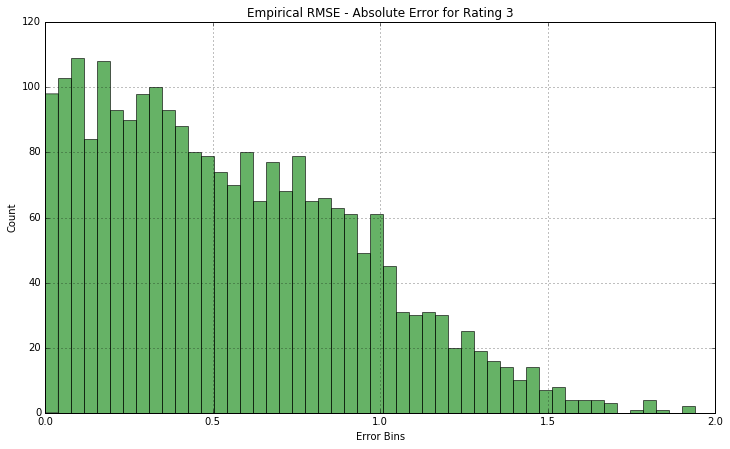

In [267]:
plt.figure(5, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for Rating 3')
plt.hist(three_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

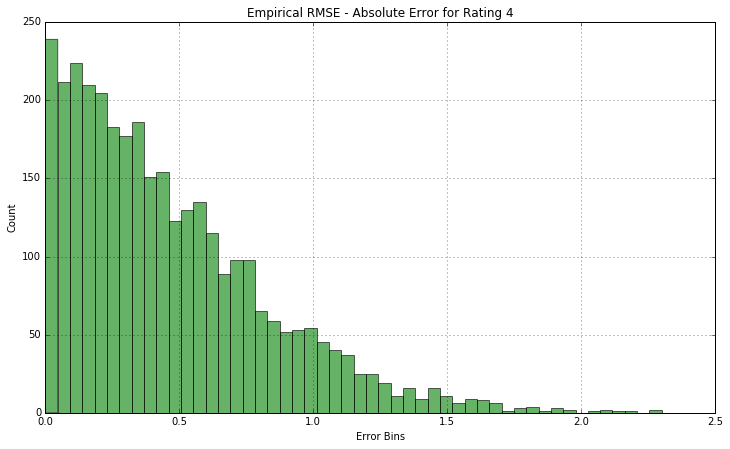

In [268]:
plt.figure(6, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for Rating 4')
plt.hist(four_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

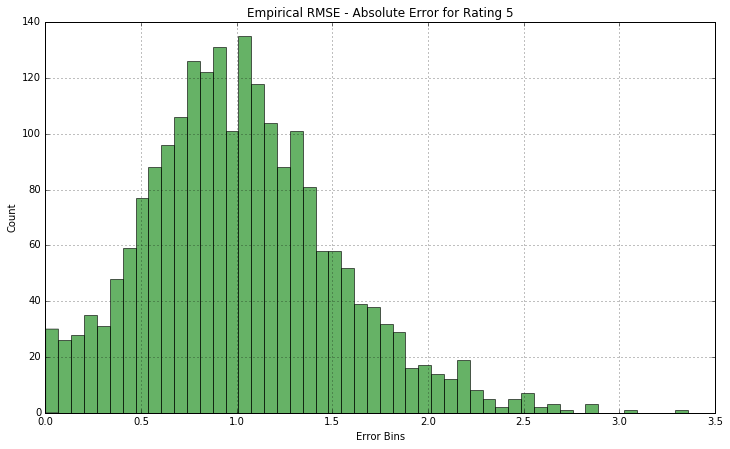

In [269]:
plt.figure(7, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for Rating 5')
plt.hist(five_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# 4.c.ii Minimized RMSE

In [270]:
# Populate error arrays for each rating group
one_error_arr = []
two_error_arr = []
three_error_arr = []
four_error_arr = []
five_error_arr = []
sigma = 0

for i, val in enumerate(u_one_test):
    error = abs(1-(mu+ opt_b_u[int(u_one_test[i])-1] + opt_b_i[int(i_one_test[i])-1]))
    one_error_arr.append(error)
    
for i, val in enumerate(u_two_test):
    error = abs(2-(mu+ opt_b_u[int(u_two_test[i])-1] + opt_b_i[int(i_two_test[i])-1]))
    two_error_arr.append(error)
    
for i, val in enumerate(u_three_test):
    error = abs(3-(mu+ opt_b_u[int(u_three_test[i])-1] + opt_b_i[int(i_three_test[i])-1]))
    three_error_arr.append(error)
    
for i, val in enumerate(u_four_test):
    error = abs(4-(mu+ opt_b_u[int(u_four_test[i])-1] + opt_b_i[int(i_four_test[i])-1]))
    four_error_arr.append(error)

for i, val in enumerate(u_five_test):
    error = abs(5-(mu+ opt_b_u[int(u_five_test[i])-1] + opt_b_i[int(i_five_test[i])-1]))
    five_error_arr.append(error)

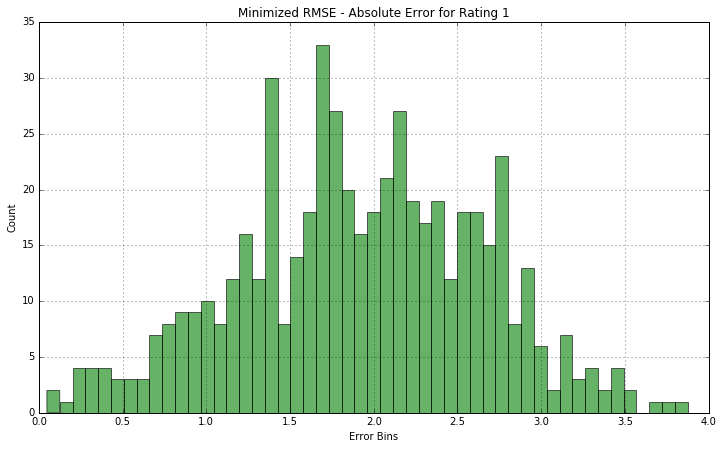

In [271]:
plt.figure(8, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for Rating 1')
plt.hist(one_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

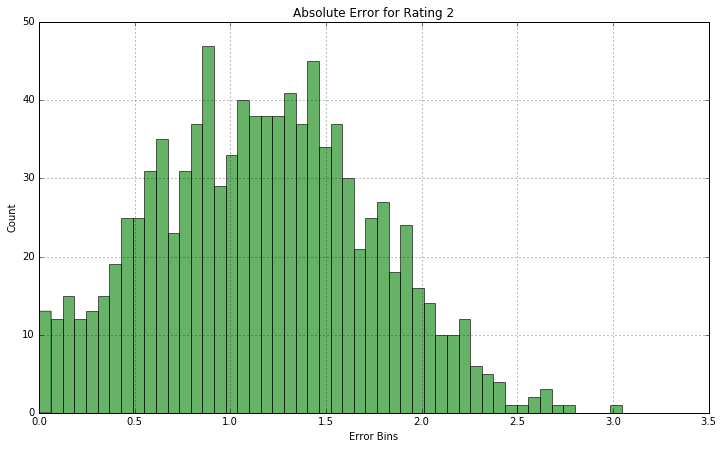

In [260]:
plt.figure(9, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for Rating 2')
plt.hist(two_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

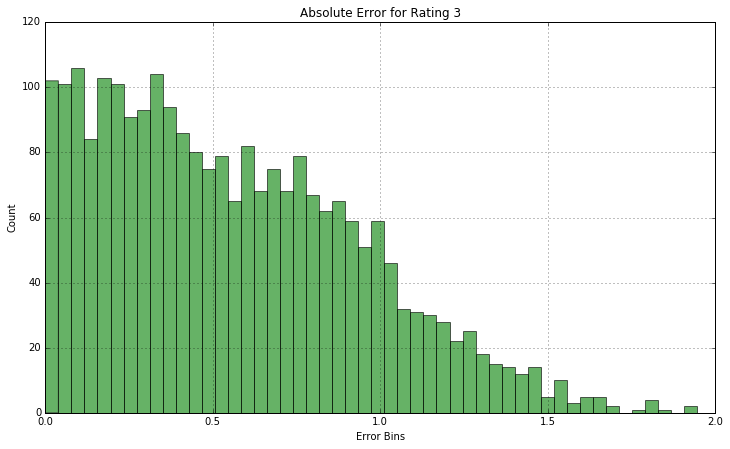

In [261]:
plt.figure(10, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for Rating 3')
plt.hist(three_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

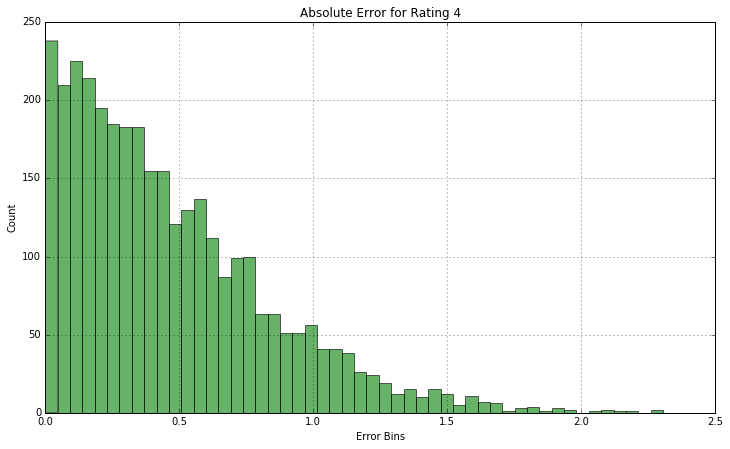

In [262]:
plt.figure(11, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for Rating 4')
plt.hist(four_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

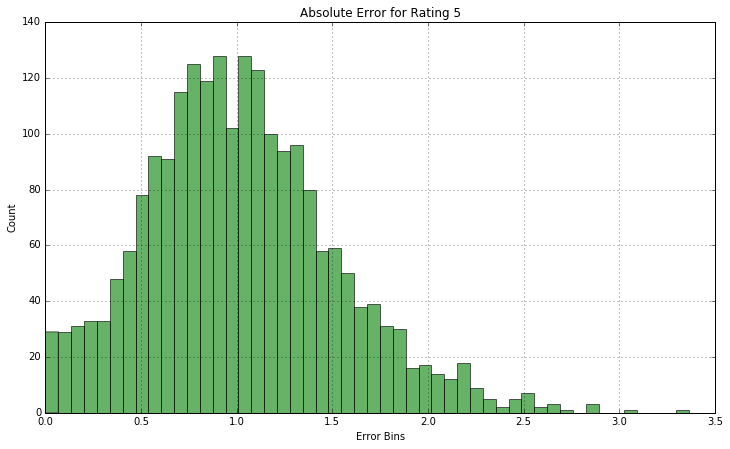

In [263]:
plt.figure(12, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for Rating 5')
plt.hist(five_error_arr, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# Question 4.c.iii Empirical RMSE

In [281]:
print max(emp_b_u) + mu, min(emp_b_u) + mu, len(emp_b_u)
test_mat = csc_matrix((t_rating, (u_test, i_test)))
test_mat = test_mat[1:,1:]

4.92857142857 1.48941176471 943


In [282]:
print list(test_mat.getrow(i).indices)

[10, 57, 110, 185, 214, 231, 355, 569, 807, 1066]


In [297]:
# create 5 bin arrays
first_bin = []
second_bin = []
third_bin = []
fourth_bin = []
fifth_bin = []

# create 5 bin error arrays
first_bin_err = []
second_bin_err = []
third_bin_err = []
fourth_bin_err = []
fifth_bin_err = []

# find bin size
min_val = min(emp_b_u)
max_val = max(emp_b_u)
bin_length = (max_val - min_val)/5

# create bin values
zero_val = min(emp_b_u)
first_val = zero_val + bin_length
second_val = first_val + bin_length
third_val = second_val + bin_length
fourth_val = third_val + bin_length
fifth_val = fourth_val + bin_length

# populate bin arrays
for i,val in enumerate(emp_b_u):
    if val >= zero_val and val < first_val:
        first_bin.append(i)
    elif val >= first_val and val < second_val:
        second_bin.append(i)
    elif val >= second_val and val < third_val:
        third_bin.append(i)
    elif val >= third_val and val < fourth_val:
        fourth_bin.append(i)
    elif val >= fourth_val and val <= fifth_val:
        fifth_bin.append(i)

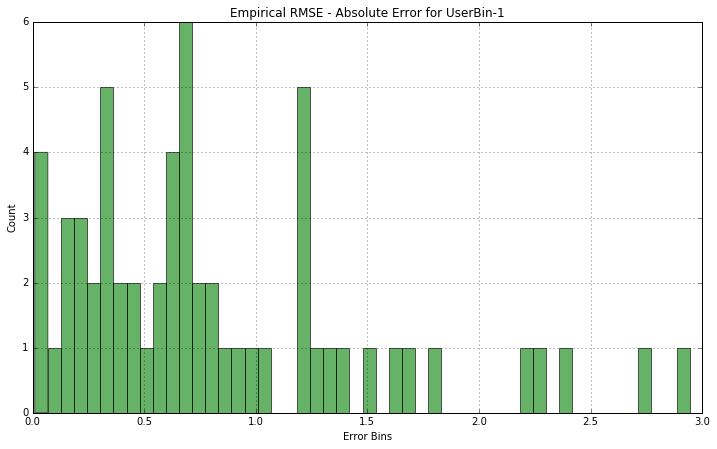

In [299]:
for i,val in enumerate(first_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        first_bin_err.append(abs(float(test_mat[val,ind] - (mu + emp_b_u[val] + emp_b_i[ind]))))
        
plt.figure(13, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for UserBin-1')
plt.hist(first_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

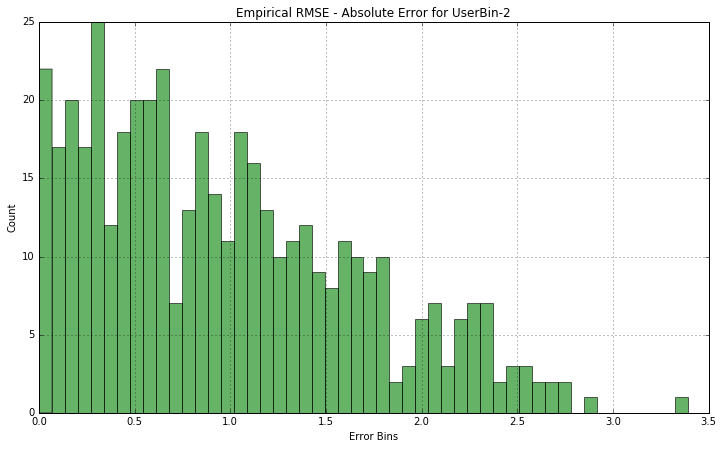

In [300]:
for i,val in enumerate(second_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        second_bin_err.append(abs(float(test_mat[val,ind] - (mu + emp_b_u[val] + emp_b_i[ind]))))
        
plt.figure(14, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for UserBin-2')
plt.hist(second_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

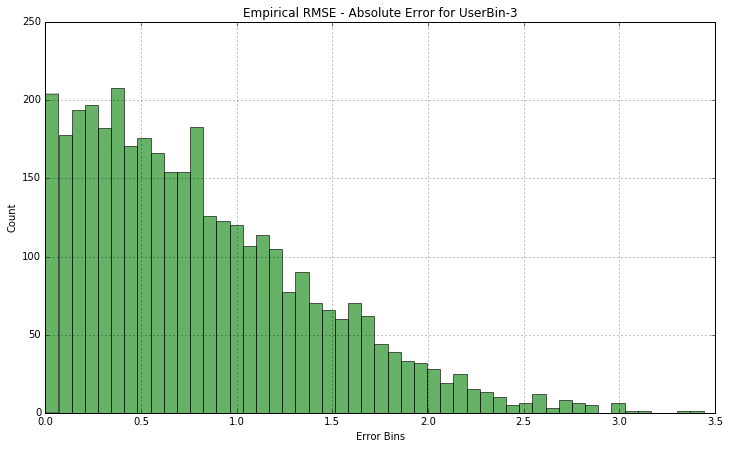

In [301]:
for i,val in enumerate(third_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        third_bin_err.append(abs(float(test_mat[val,ind] - (mu + emp_b_u[val] + emp_b_i[ind]))))
        
plt.figure(15, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for UserBin-3')
plt.hist(third_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

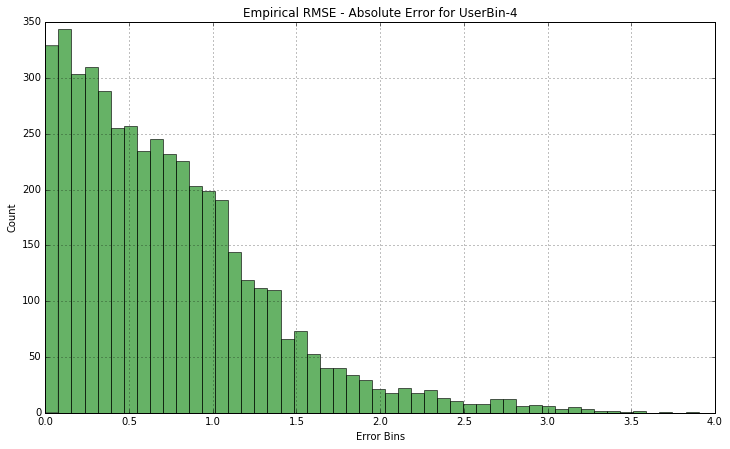

In [302]:
for i,val in enumerate(fourth_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        fourth_bin_err.append(abs(float(test_mat[val,ind] - (mu + emp_b_u[val] + emp_b_i[ind]))))
        
plt.figure(16, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for UserBin-4')
plt.hist(fourth_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

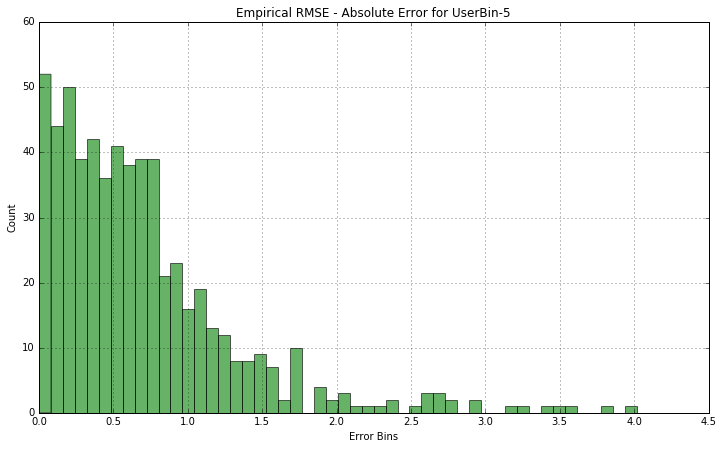

In [303]:
for i,val in enumerate(fifth_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        fifth_bin_err.append(abs(float(test_mat[val,ind] - (mu + emp_b_u[val] + emp_b_i[ind]))))
        
plt.figure(17, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Empirical RMSE - Absolute Error for UserBin-5')
plt.hist(fifth_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# 4.c.iii Minimized RMSE

In [304]:
# create 5 bin error arrays
first_bin_err = []
second_bin_err = []
third_bin_err = []
fourth_bin_err = []
fifth_bin_err = []

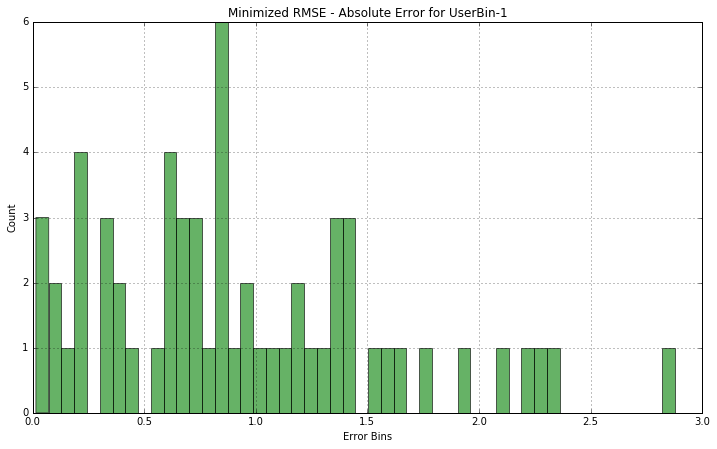

In [305]:
for i,val in enumerate(first_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        first_bin_err.append(abs(float(test_mat[val,ind] - (mu + opt_b_u[val] + opt_b_i[ind]))))
        
plt.figure(18, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for UserBin-1')
plt.hist(first_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

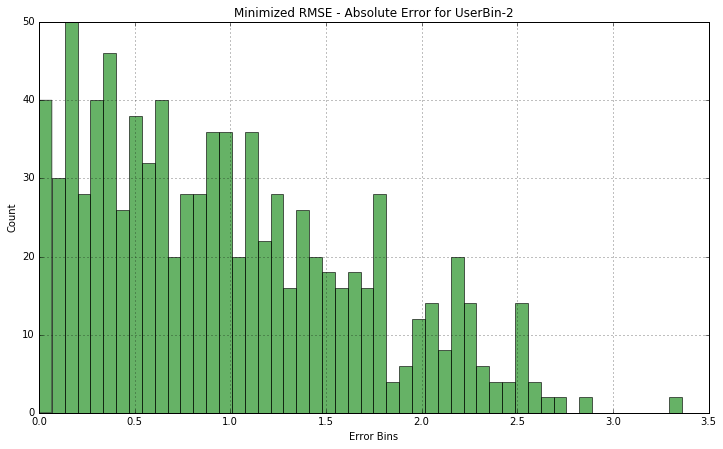

In [311]:
for i,val in enumerate(second_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        second_bin_err.append(abs(float(test_mat[val,ind] - (mu + opt_b_u[val] + opt_b_i[ind]))))
        
plt.figure(19, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for UserBin-2')
plt.hist(second_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

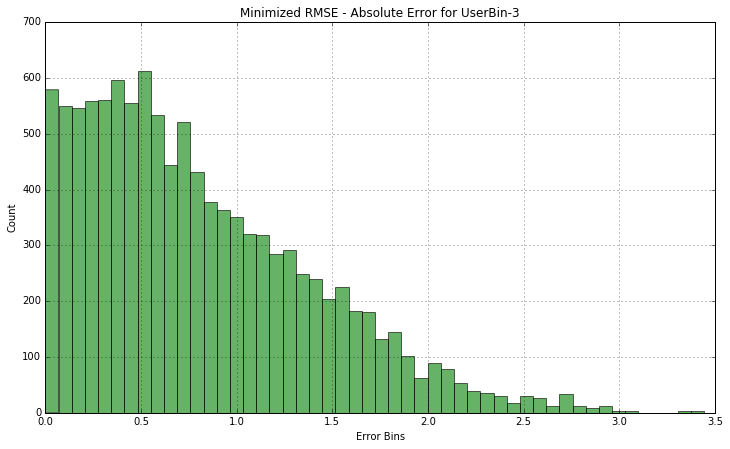

In [312]:
for i,val in enumerate(third_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        third_bin_err.append(abs(float(test_mat[val,ind] - (mu + opt_b_u[val] + opt_b_i[ind]))))
        
plt.figure(20, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for UserBin-3')
plt.hist(third_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

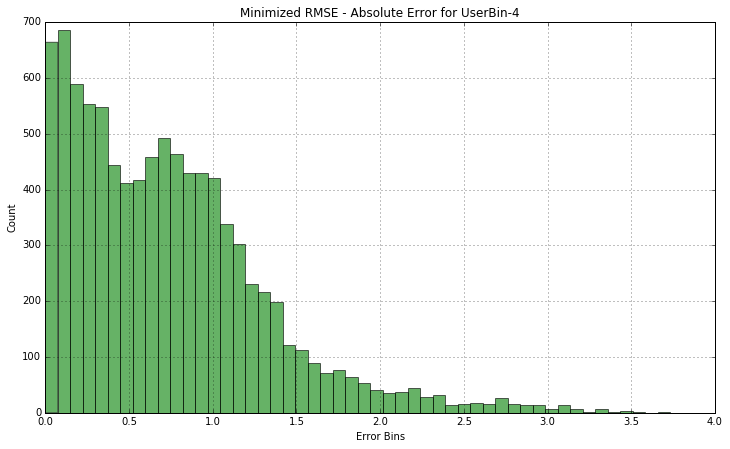

In [313]:
for i,val in enumerate(fourth_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        fourth_bin_err.append(abs(float(test_mat[val,ind] - (mu + opt_b_u[val] + opt_b_i[ind]))))
        
plt.figure(21, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for UserBin-4')
plt.hist(fourth_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

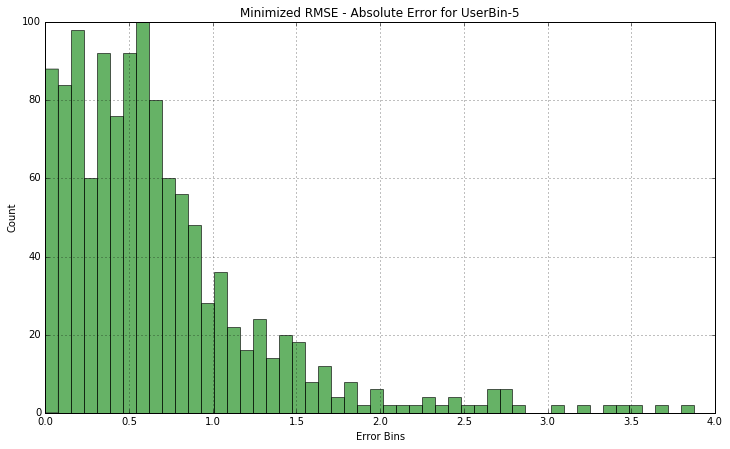

In [314]:
for i,val in enumerate(fifth_bin):
    item_arr = list(test_mat.getrow(val).indices)
    for ind in item_arr:
        fifth_bin_err.append(abs(float(test_mat[val,ind] - (mu + opt_b_u[val] + opt_b_i[ind]))))
        
plt.figure(22, figsize=(12, 7))
plt.xlabel('Error Bins')
plt.ylabel('Count')
plt.title('Minimized RMSE - Absolute Error for UserBin-5')
plt.hist(fifth_bin_err, bins=50, facecolor='green', alpha=0.6)
plt.grid(True)
plt.show()

# Question 5.a

In [199]:
from itertools import combinations
sim_dict = {}
iter_list = [x for x in range(mat.shape[1])]
for comb in combinations(iter_list, 2):
        i,j = comb
        if i == j:
            sim_dict[(i,j)] = 1
            sim_dict[(j,i)] = 1
            
        common_users = list(set(users_per_column[i]).intersection(set(users_per_column[j])))
        num_sum = 0.0
        den_a = 0.0
        den_b = 0.0
        if len(common_users) > 5:
            for user in common_users:
                avg = b_u[user] + mu
                num_sum += (mat[user, i] - avg) * (mat[user, j] - avg)
                den_a += (mat[user, i] - avg)**2
                den_b += (mat[user, j] - avg)**2
            den_sum = (den_a * den_b)**0.5
            sim_dict[(i,j)] = num_sum/float(den_sum)
            sim_dict[(j,i)] = num_sum/float(den_sum)
        else:
            if len(common_users) > 1:
                for user in common_users:
                    avg = b_u[user] + mu
                    num_sum += (mat[user, i] - avg) * (mat[user, j] - avg)
                    den_a += (mat[user, i] - avg)**2
                    den_b += (mat[user, j] - avg)**2
                den_sum = (den_a * den_b)**0.5
                sim_dict[(i,j)] = num_sum/(2*float(den_sum))
                sim_dict[(j,i)] = num_sum/(2*float(den_sum))
            elif len(common_users) == 1:
                for user in common_users:
                    avg = b_u[user] + mu
                    num_sum += (mat[user, i] - avg) * (mat[user, j] - avg)
                    den_a += (mat[user, i] - avg)**2
                    den_b += (mat[user, j] - avg)**2
                den_sum = (den_a * den_b)**0.5
                sim_dict[(i,j)] = num_sum/(4*float(den_sum))
                sim_dict[(j,i)] = num_sum/(4*float(den_sum)) 
            else:
                sim_dict[(i,j)] = 0
                sim_dict[(j,i)] = 0

        if (j % 1681) == 0:
            print i
                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [200]:
for i in range(mat.shape[1]):
    sim_dict[(i,i)] = 0.25

In [201]:
sim_rows = [key[0] for key in sim_dict.keys()]
sim_cols = [key[1] for key in sim_dict.keys()]
sim_vals = sim_dict.values()
sim_mat = csc_matrix((sim_vals, (sim_rows, sim_cols)), shape=(mat.shape[1], mat.shape[1]))

In [206]:
from operator import itemgetter
k_arr = [1,2,3,5,10]
rmse_arr = []
for k in k_arr:
    rmse = 0.0
    rmse_num = 0.0
    p_mat = {}
    count = 0
    for u,u_id in enumerate(u_test):
        sim_movie_arr = []
        sim_score_arr = []
        sim_ind_arr = []
        ind_arr = []
        num_sum = 0
        # all the movies that user has rated
        movie_ind_arr = list(test_mat.getrow(u_id-1).nonzero()[1])
        movie_ind_arr.remove(i_test[u]-1)

        # find similarity scores for movies that user has rated
        for val in movie_ind_arr:
            sim_movie_arr.append(sim_mat[val,i_test[u]-1])

        # sort both the above arrays by sim_score
        zipped = zip(sim_movie_arr, movie_ind_arr)
        sorted_zipped = sorted(zipped, key=itemgetter(0))
        arr_arr = [list(t) for t in zip(*sorted_zipped)]
        sorted_arr = arr_arr[0]
        ind_arr = arr_arr[1]

        # take the last k similarity scores and similarity indices
        for k_val in range(k):
            sim_score_arr.append(sorted_arr[len(sorted_arr)-1-k_val])
            sim_ind_arr.append(ind_arr[len(ind_arr)-1-k_val])

        weighted_sum = 0.0
        num = 0.0
        den = 0.0

        # start calculating 
        for i,ind in enumerate(sim_ind_arr):
            try:
                if test_mat[u_id-1,ind] != 0:
                    num += abs((sim_score_arr[i] * float(test_mat[u_id-1,ind])))
                else:
                    num += abs((sim_score_arr[i] * mu)) 
            except:
                print 'error'
                num += abs(sim_score_arr[i]* mu)

        for sum_val in sim_score_arr:
            den += abs(sum_val)
        
        # error checking and compensating
        if den == 0 or num == 0:
            for ind in sim_ind_arr:
                num_sum += abs(float(test_mat[u_id-1,ind]))
            weighted_sum = num_sum/float(k)
        else:
            weighted_sum = num/float(den)

        if weighted_sum == 0:
            print num, den, float(test_mat[u_id-1,ind]), num_sum, float(k), 'mu'
            weighted_sum = mu
        
        # not being used now, redundant dict
        p_mat[(u_id,i_test[u])] = weighted_sum

        try:
            if test_mat[u_id-1,i_test[u]-1] == 0:
                rmse_num += (mu - weighted_sum)**2
            else:
                rmse_num += (test_mat[u_id-1,i_test[u]-1] - weighted_sum)**2
        except:
            print u_id, i_test[u]
        
    rmse = (rmse_num/float(len(t_rating)))**0.5
    print 'k=', k, ':', rmse
    rmse_arr.append(rmse)
print rmse_arr
    
            

k= 1 : 1.32473811414
k= 2 : 1.16542154912
k= 3 : 1.11402130752
k= 5 : 1.07719518503
k= 10 : 1.10509181157
[1.3247381141379759, 1.165421549119485, 1.1140213075238981, 1.0771951850270363, 1.105091811565043]
